In [1]:
import pandas as pd
import numpy as np
import os

from xgboost import XGBClassifier
# scikit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
)

from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
    StratifiedKFold,
)
from sklearn.tree import DecisionTreeClassifier

In [2]:
malicious_features = pd.read_pickle("data/malicious_features.pkl")
benign_features = pd.read_pickle("data/benign_features.pkl")

In [3]:
malicious_features.pop("Payload")
benign_features.pop("Payload")

4           Raw
5           Raw
6           Raw
7           Raw
26          Raw
          ...  
38585    Radius
38586    Radius
38587    Radius
38588    Radius
38589    Radius
Name: Payload, Length: 18615, dtype: object

# Labeling
We label and concatenate benign and malicious before one-hot because there are different ports in each dataset and concatenating the two after one hot will not work with different columns.

In [4]:
# add labels, 0 for benign, 1 for malicious
malicious_features["Labels"] = 1
benign_features["Labels"] = 0

In [5]:
# concatenate dataframes
data_df = pd.concat(
    [malicious_features, benign_features], ignore_index=True
)

# Model Training
- We use some characteristic models for demonstration purposes. Models need to be tuned by exploring their hyperparameters and compared in order to pick the best one for the application.
  - xgboost
  - NN
  - k-NN
  - Random Forest
- k-fold cross validation
  - split the data in k parts
  - use one part for testing, the other k-1 parts for training the model
  - repeat for all the combinations of k parts using a different one for testing, the other k-1 for training the model

In [6]:
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

In [7]:
# randomize the data. TODO: is this needed??
data_df = shuffle(data_df)

In [8]:
# after feature engineering, drop all the columns that are unnecessary
data_df = data_df.drop(["Source Port", "Destination Port"], axis=1)

In [9]:
# store the features and labels in separate dataframes
X = data_df.drop("Labels", axis=1)
y = data_df["Labels"]

In [10]:
# convert data to array
data_array = data_df.to_numpy()

In [11]:
# print splits for better understanding
model = 1
for train, test in kfold.split(data_array):
    print(f"Model {model}")
    print(f"train {train}, test: {test}")
    model += 1

Model 1
train [     0      2      3 ... 172701 172702 172704], test: [     1      4     13 ... 172694 172697 172703]
Model 2
train [     0      1      2 ... 172701 172703 172704], test: [     6      8     10 ... 172681 172690 172702]
Model 3
train [     0      1      2 ... 172701 172702 172703], test: [    17     18     23 ... 172687 172693 172704]
Model 4
train [     0      1      4 ... 172702 172703 172704], test: [     2      3     11 ... 172699 172700 172701]
Model 5
train [     1      2      3 ... 172702 172703 172704], test: [     0      5      7 ... 172689 172696 172698]


## Model selection

We picked three characteristic models:
- Decision Tree
- Random Forest
- XGB

In [12]:
decision_tree = DecisionTreeClassifier()

In [13]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=2, random_state=0)

In [14]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)

# Model Evaluation

## Metrics
We compare all models using the following metrics:
- accuracy: Accuracy is the proportion of correct predictions to the total number of predictions.
- precision: Precision measures the proportion of true positives to the total predicted positives.
- recall: Recall (also known as sensitivity or true positive rate) measures the proportion of true positives to the total actual positives.
- f1 score

Note: we use the models out of box without fine tuning them.

In [15]:
def k_fold_validation_metrics(model, k, X, y):
    # Initialize lists to store evaluation metrics for each fold
    precision_scores = []
    accuracy_scores = []
    recall_scores = []
    f1_scores = []

    # convert dataframes to numpy arrays
    X = X.values
    y = y.values

    # Create k-fold cross-validation iterator
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X, y):
        # Split the data into train and test sets for each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics for this fold
        precision = precision_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Append the scores to the respective lists
        precision_scores.append(precision)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Calculate the average of the evaluation metrics over all folds
    avg_precision = np.mean(precision_scores)
    avg_accuracy = np.mean(accuracy_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return {
        "Average Precision": avg_precision,
        "Average Accuracy": avg_accuracy,
        "Average Recall": avg_recall,
        "Average F1-Score": avg_f1,
    }

In [16]:
dt_evaluation = k_fold_validation_metrics(decision_tree, k, X, y)
dt_evaluation

{'Average Precision': 1.0,
 'Average Accuracy': 1.0,
 'Average Recall': 1.0,
 'Average F1-Score': 1.0}

In [17]:
rf_evaluation = k_fold_validation_metrics(rf, k, X, y)
rf_evaluation

{'Average Precision': 0.97562326691169,
 'Average Accuracy': 0.9777018615558323,
 'Average Recall': 1.0,
 'Average F1-Score': 0.9876597784847366}

In [18]:
xgb_evaluation = k_fold_validation_metrics(xgb, k, X, y)
xgb_evaluation

{'Average Precision': 1.0,
 'Average Accuracy': 1.0,
 'Average Recall': 1.0,
 'Average F1-Score': 1.0}

## Confusion matrix

A confusion matrix is a table that visualizes the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X, y):
    # Initialize an empty confusion matrix
    cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)

    # Perform k-fold cross-validation and accumulate the confusion matrix
    predictions = cross_val_predict(model, X, y, cv=5)  # Change cv value as needed
    cm += confusion_matrix(y, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

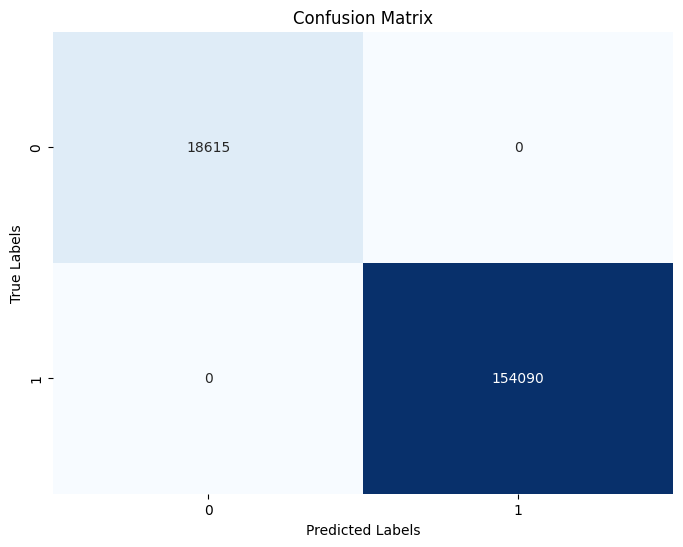

In [20]:
plot_confusion_matrix(decision_tree, X, y)

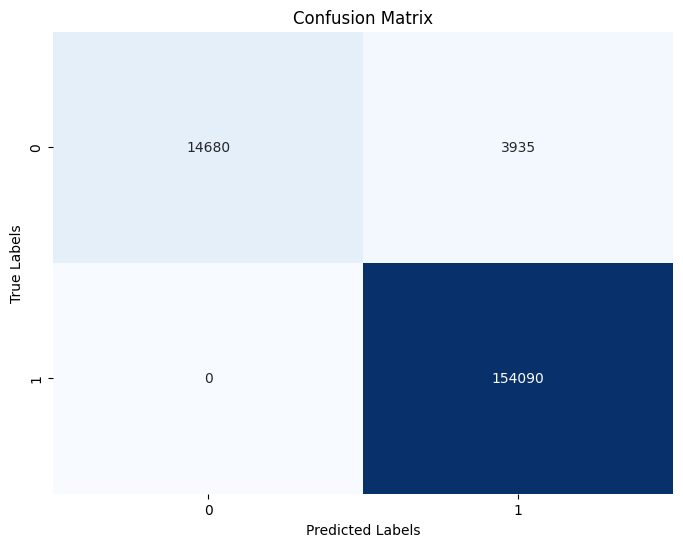

In [21]:
plot_confusion_matrix(rf, X, y)

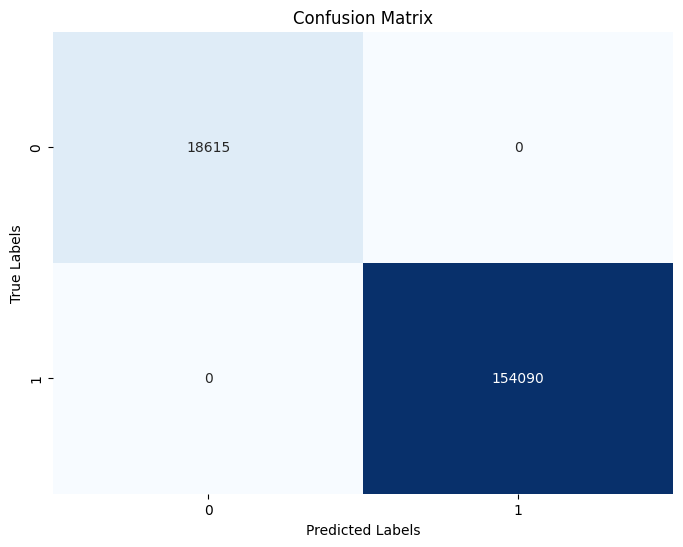

In [22]:
plot_confusion_matrix(xgb, X, y)

## ROC curve

Use a ROC curve to visualize the model evaluation:
- The X-axis indicates the False Positive Rate
- The Y-axis indicates the True Positive Rate
- The higher the area under the curve the better the model performance
- The diagonal line indicates the performance of a random classifier
- Performance at the top level corner indicates high TPR with low TPR for the same threshold

In [23]:
def plot_roc_curve(model, X, y, n_folds=5):
    # Initialize variables to store false positive rate and true positive rate for each fold
    mean_fpr = np.linspace(0, 1, 100)
    tpr_sum = 0

    X = X.values
    y = y.values

    # Create k-fold cross-validation iterator
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    plt.figure(figsize=(8, 6))

    for train, test in cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tpr_sum += np.interp(mean_fpr, fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

    mean_tpr = tpr_sum / n_folds
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random Chance")
    plt.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        lw=2,
        label="Mean ROC (AUC = {:.2f})".format(auc(mean_fpr, mean_tpr)),
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

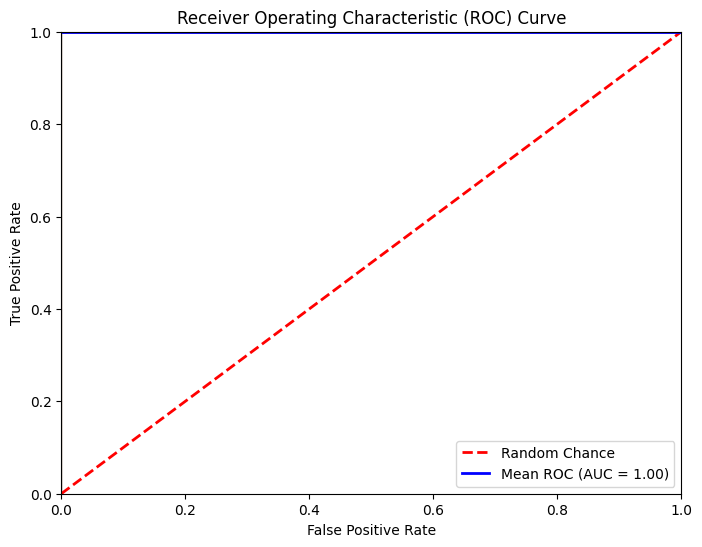

In [24]:
plot_roc_curve(decision_tree, X, y)

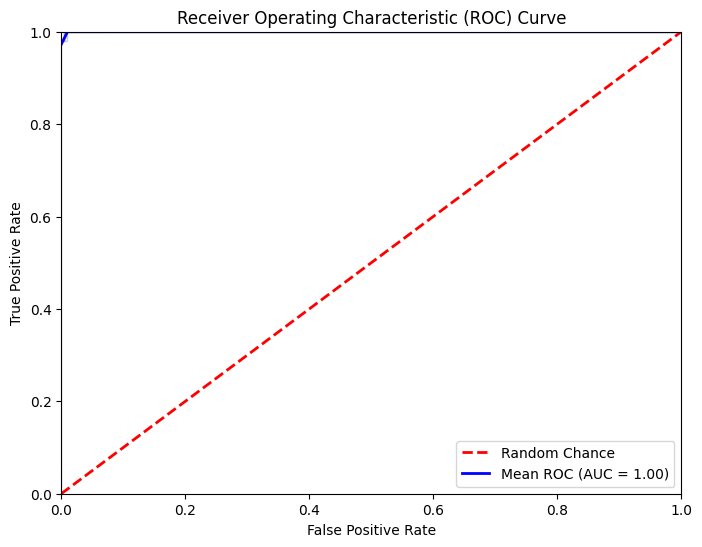

In [25]:
plot_roc_curve(rf, X, y)

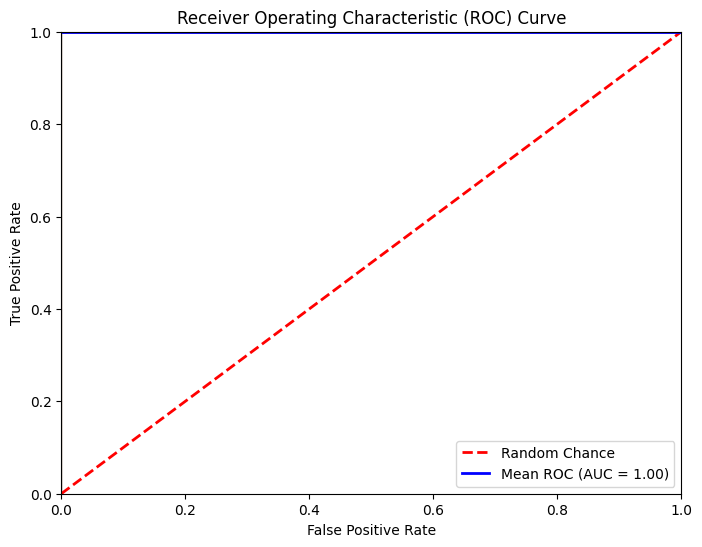

In [26]:
plot_roc_curve(xgb, X, y)